In [1]:
import pandas as pd
import numpy as np

In [2]:
pip install -U dataretrieval

Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

### Read snow and temperature data from MODIS

In [4]:
snow = pd.read_csv('data/MODIS/snow_cover.csv')
temp = pd.read_csv('data/MODIS/land_surface_temp_K.csv')

In [5]:
# Get hourly dates as list
modis_dates = snow['date'].to_list()
modis_dates = [str(date) for date in modis_dates]

In [6]:
# Reformat dates and convert to datetime objects
new_dates = []
for date in modis_dates:
    new_date = f'{date[0:4]}-{date[5:7]}-{date[8:10]}'
    new_dates.append(new_date)
new_dates   

snow['date'] = new_dates
snow['date']= pd.to_datetime(snow['date'])
snow = snow.set_index('date')

temp['date'] = new_dates
temp['date']= pd.to_datetime(temp['date'])
temp = temp.set_index('date')

# Convert Kelvin to Farenheight (MODIS has scale factor of 0.02)
temp = temp.assign(fahrenheit = lambda x: ((x['LST_Day_1km']*0.02)-273.15)*(9/5)+32)

In [7]:
temp.head(4)

,LST_Day_1km,fahrenheit
date,,
2013-01-01,13637.58888,31.283200
2013-01-02,13726.96287,34.500663
2013-01-03,13740.39250,34.984130
2013-01-04,13486.85150,25.856654


### Read GPM precipitation data

In [8]:
prec_hourly = pd.read_csv('data/MODIS/precipitation.csv')

In [9]:
# Get hourly dates as list
gpm_dates = prec_hourly['date'].to_list()
gpm_dates = [str(date) for date in gpm_dates]

In [10]:
# Convert to date to datetime objects
new_dates = []
for date in gpm_dates:
    new_date = f'{date[0:4]}-{date[4:6]}-{date[6:8]} {date[8:10]}:{date[10:12]}:00'
    new_dates.append(new_date)
prec_hourly['date'] = new_dates
prec_hourly['date']= pd.to_datetime(prec_hourly['date'])
prec_hourly = prec_hourly.set_index('date')

In [11]:
# Resample to daily intervals
prec_daily = prec_hourly.resample('D').sum()

### Create new dataframe with all satellite variables

In [12]:
satellite = pd.DataFrame()
satellite['snow'] = snow['NDSI_Snow_Cover']
satellite['temp'] = temp['fahrenheit']
satellite['prec'] = prec_daily['precipitationCal']

In [13]:
import dataretrieval.nwis as nwis
# Add discharge to dataframe
# specify the USGS site code for which we want data.
nisqually = '12082500' #nisqually river
puyallup = '12092000' #puyallup basin
cowlitz = '14226500' #cowlitz basin

# get instantaneous values (iv)
nisDis = nwis.get_record(sites=nisqually, service='dv', start='2013-01-01', end='2021-12-31')
discharge = nisDis['00060_Mean']

In [14]:
# Strangling with dates as always
nisDis['date'] = nisDis.index
nisDis['date'] = pd.to_datetime(nisDis['date'], utc = False)
nisDis['date'] = nisDis['date'].astype(str)
dates = nisDis['date'].to_list()
new_dates = []
for date in dates:
    new_date = date[0:10]
    new_dates.append(new_date)
nisDis['date'] = new_dates

In [15]:
discharge = pd.DataFrame()
discharge['date'] = nisDis['date']
discharge['nisqually_discharge'] = nisDis['00060_Mean']
discharge.reset_index(drop=True, inplace=True)
discharge['date'] = pd.to_datetime(discharge['date'])
discharge.set_index('date')

,nisqually_discharge
date,
2013-01-01,424.0
2013-01-02,413.0
2013-01-03,404.0
2013-01-04,423.0
2013-01-05,426.0
...,...
2021-12-27,656.0
2021-12-28,610.0
2021-12-29,567.0


In [16]:
satellite = satellite.merge(discharge, on='date')
satellite = satellite.set_index('date')
satellite

,snow,temp,prec,nisqually_discharge
date,,,,
2013-01-01,56.669666,31.283200,25.122626,424.0
2013-01-02,52.070299,34.500663,0.235298,413.0
2013-01-03,51.463661,34.984130,0.010412,404.0
2013-01-04,65.101677,25.856654,11.616317,423.0
2013-01-05,NaN,NaN,159.500557,426.0
...,...,...,...,...
2021-12-27,42.476682,1.240611,45.353518,656.0
2021-12-28,NaN,NaN,96.939873,610.0
2021-12-29,61.435763,4.933996,0.726814,567.0


<AxesSubplot:title={'center':'Precipitation'}, xlabel='date', ylabel='precipitation (mm)'>

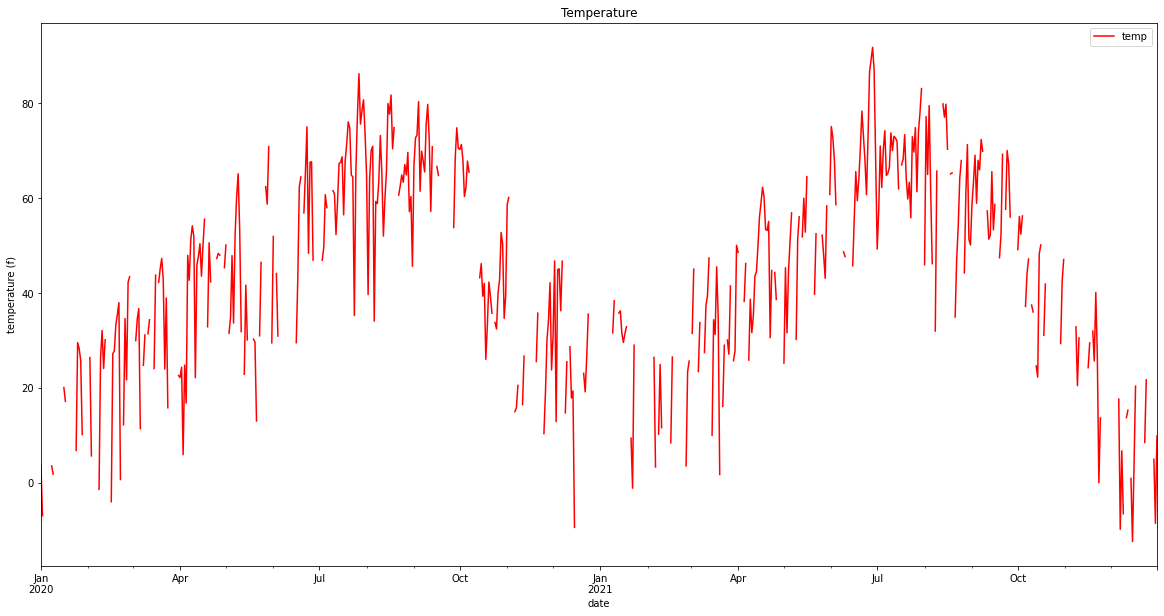

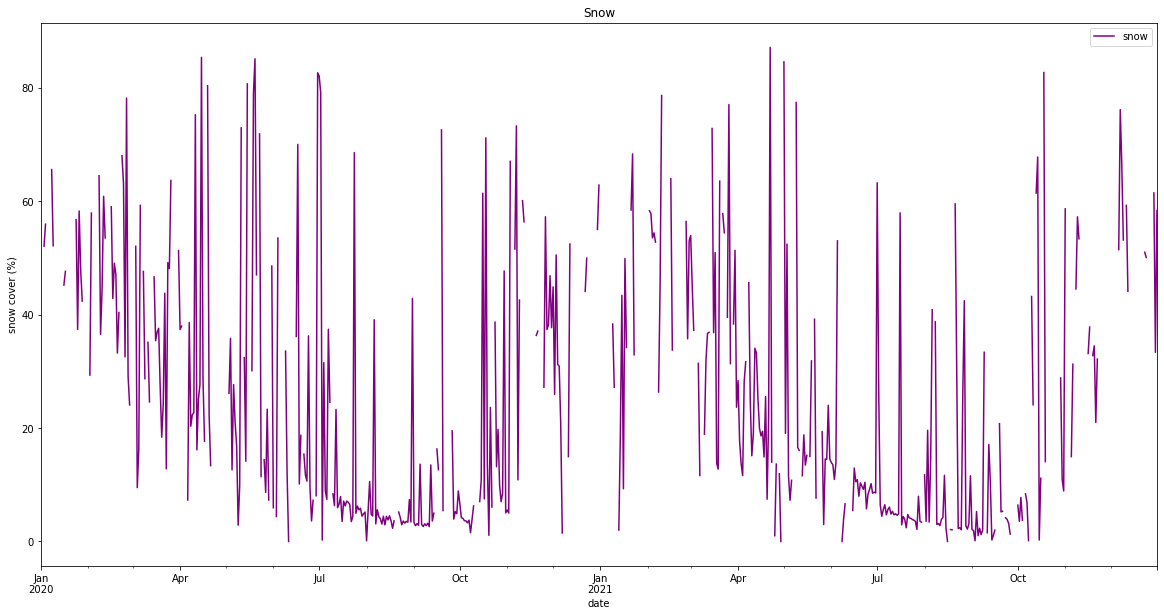

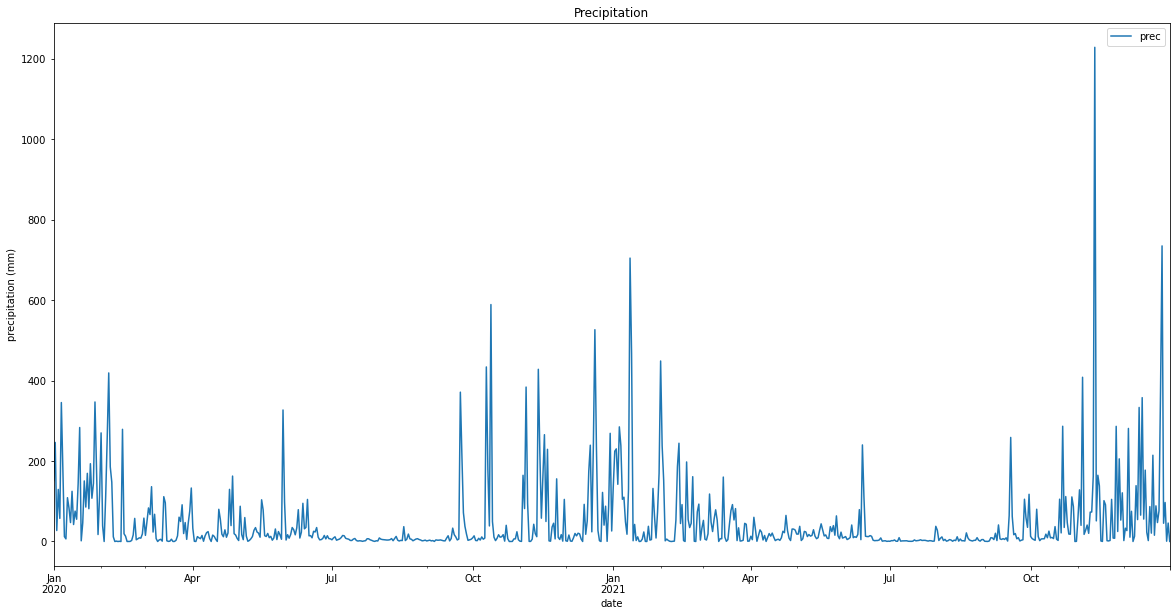

In [17]:
# Plot 2020-2021
satellite.loc['2020-01-01':'2021-12-31'].plot(y='temp', kind ='line', figsize=(20,10), ylabel='temperature (f)', title='Temperature', color='red')
satellite.loc['2020-01-01':'2021-12-31'].plot(y='snow', kind ='line', figsize=(20,10), ylabel='snow cover (%)', title='Snow', color='purple')
satellite.loc['2020-01-01':'2021-12-31'].plot(y='prec', kind ='line', figsize=(20,10), ylabel='precipitation (mm)', title='Precipitation')

## Set up machine learning model to predict discharge using satellite data

In [18]:
satellite.dropna(inplace=True)

In [19]:
# Define feature list
feature_list =  ['snow', 'temp', 'prec']

In [20]:
# Compute correlation matrix
corr_matrix = satellite.corr()

# Display just house value correlations
corr_matrix["nisqually_discharge"].sort_values(ascending= False)

nisqually_discharge    1.000000
prec                   0.297581
snow                   0.196755
temp                  -0.184590
Name: nisqually_discharge, dtype: float64

In [21]:
# Define features and labels 
X = satellite[feature_list]
y = satellite['nisqually_discharge']

# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)

In [22]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [23]:
from sklearn.ensemble import RandomForestRegressor

# Define model
forest_reg = RandomForestRegressor(n_estimators = 100)

# Fit model
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [24]:

# Predict test labels predictions
predictions = forest_reg.predict(X_test)

# Compute mean-squared-error
final_mse = mean_squared_error(y_test , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

348.293988874593

(0.0, 3000.0)

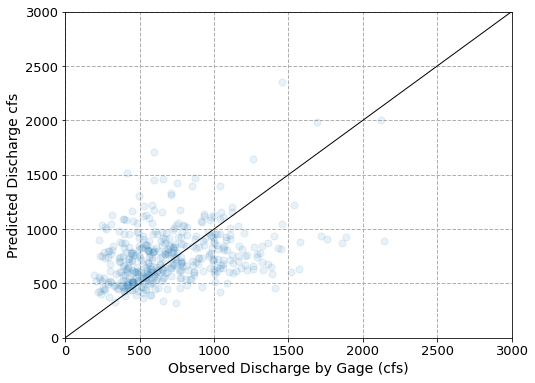

In [31]:
import matplotlib.pyplot as plt
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, predictions, alpha=0.1, s=50, zorder=2)
ax.plot([0,3000], [0, 3000], color='k', lw=1, zorder=3)
ax.set_ylabel('Predicted Discharge cfs', fontsize=14)
ax.set_xlabel('Observed Discharge by Gage (cfs)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.set_ylim(0,3000)
ax.set_xlim(0,3000)